# Example - Animal Shelter

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Target" data-toc-modified-id="Target-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Target</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#Feature-Importance-migration" data-toc-modified-id="Feature-Importance-migration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Importance migration</a></span></li><li><span><a href="#Reverse-Learning-Curve" data-toc-modified-id="Reverse-Learning-Curve-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reverse Learning Curve</a></span></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Performance comparison</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Feature-Impact" data-toc-modified-id="Feature-Impact-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Feature Impact</a></span></li><li><span><a href="#Minimum-samples-by-period-effect" data-toc-modified-id="Minimum-samples-by-period-effect-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Minimum samples by period effect</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Domain classifier</a></span></li><li><span><a href="#Other-optimization-design-for-the-RF" data-toc-modified-id="Other-optimization-design-for-the-RF-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Other optimization design for the RF</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from time_robust_forest.hyper_opt import env_wise_hyper_opt
from aux_functions import *

np.random.seed(42)

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
DATASETS_PATH = "~/Documents/datasets/animal_shelter/"
PREFIX = "animal_shelter"

In [5]:
intakes = pd.read_csv(DATASETS_PATH + "Austin_Animal_Center_Intakes.csv")
outcomes = pd.read_csv(DATASETS_PATH + "Austin_Animal_Center_Outcomes.csv")

In [6]:
intakes["Age upon Intake"] = intakes["Age upon Intake"].apply(lambda x: float(x.split(" ")[0]) / 12.0 if "month" in x else float(x.split(" ")[0]))
outcomes.rename(columns={"DateTime": "Outcome DateTime", "Outcome Type": "Outcome"},
                inplace=True)

data = intakes.merge(outcomes[["Animal ID", "Outcome DateTime", "Outcome"]], on="Animal ID")
data["time_until_adoption"] = (pd.to_datetime(data["Outcome DateTime"]) - pd.to_datetime(data["DateTime"])).dt.days
data["target"] = (data["time_until_adoption"] < 30) & (data["Outcome"] == "Adoption")
data["target"] = data["target"].astype(int)
data["target"].mean()

0.2998167402199117

In [7]:
data.shape

(160428, 16)

In [8]:
#data = data.sample(frac=0.10)

### Data

In [9]:
TIME_COLUMN = "Year"
TARGET = "target"

In [10]:
columns_to_label_encode = ["Intake Type", 
                           "Intake Condition",
                           "Animal Type",
                           "Sex upon Intake",
                           "Breed",
                           "Color"]

In [11]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

Intake Type
Intake Condition
Animal Type
Sex upon Intake


/home/jovyan/.conda/envs/msc-2/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Breed
Color


In [12]:
features = ["Age upon Intake"] + columns_to_label_encode

In [13]:
data["Year"] = pd.to_datetime(data["DateTime"]).apply(lambda x: int(x.year))

In [14]:
numerical_features = [f for f in features if f not in columns_to_label_encode]

In [15]:
data["Year"].value_counts()

2019    25595
2015    23981
2017    23741
2016    23565
2018    23409
2014    22803
2020    11404
2013     4936
2021      994
Name: Year, dtype: int64

In [16]:
training_start_year = 2014
training_end_year = 2017
holdout_end_year = 2020

In [17]:
in_time = data[data["Year"] <= training_end_year]
in_time = in_time[in_time["Year"] >= training_start_year]
out_of_time = data[data["Year"] > training_end_year]
out_of_time = out_of_time[out_of_time["Year"] <= holdout_end_year]

In [18]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [19]:
train.shape

(75272, 17)

In [20]:
test.shape

(18818, 17)

In [21]:
out_of_time.shape

(60408, 17)

In [22]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)

/home/jovyan/.conda/envs/msc-2/lib/python3.6/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Checking the support in the different environments

In [23]:
check_categoricals_match(train, columns_to_label_encode, "Year")

Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Intake Type, dtype: float64
Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Intake Condition, dtype: float64
Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Animal Type, dtype: float64
Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Sex upon Intake, dtype: float64
Year
2014    0.580352
2015    0.560598
2016    0.429792
2017    0.413241
Name: Breed, dtype: float64
Year
2014    0.645435
2015    0.613588
2016    0.611465
2017    0.626327
Name: Color, dtype: float64


0.8533665917389023

In [24]:
check_numerical_match(train, numerical_features, TIME_COLUMN, verbose=True, n_q=10)

Year
2014    0.8
2015    0.9
2016    1.0
2017    0.9
Name: Age upon Intake_quant, dtype: float64


/home/jovyan/.conda/envs/msc-2/lib/python3.6/site-packages/time_robust_forest/functions.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels=[i for i in range(1, n_q + 1)],


0.9

### Benchmark

In [25]:
from pycaret.classification import *

In [26]:
TARGET

'target'

In [27]:
clf1 = setup(train[features + [TARGET]], 
             target=TARGET,
             session_id=2, 
             log_experiment=False, 
             experiment_name="{}".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6874,0.7817,0.7666,0.4708,0.5834,0.3554,0.3825
1,0.7006,0.7946,0.7866,0.4849,0.6000,0.3816,0.4102
2,0.6859,0.7772,0.7746,0.4696,0.5847,0.3557,0.3846
3,0.6942,0.7871,0.7840,0.4784,0.5942,0.3712,0.4004
4,0.6962,0.7905,0.7767,0.4803,0.5935,0.3719,0.3993
Mean,0.6929,0.7862,0.7777,0.4768,0.5912,0.3671,0.3954
SD,0.0055,0.0062,0.0071,0.0058,0.0063,0.0102,0.0104


In [28]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [29]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [30]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_sklearn"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_sklearn"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_sklearn"]))

0.7946691360135414
0.7872893826981108
0.7892606343491081


In [31]:
params_grid = {"n_estimators": [120], 
              "max_depth": [8, 12],
              "min_impurity_decrease": [1e-3, 1e-6, 0],
              "min_sample_periods": [1, 5, 10],
              "period_criterion": ["max", "avg"]}

params_grid_benchmark = params_grid.copy()
params_grid_benchmark.pop("period_criterion")

# params_grid_benchmark = {"n_estimators": [5], 
#               "max_depth": [5],
#               "min_impurity_decrease": [0.001],
#               "min_sample_periods": [5]}

['max', 'avg']

In [32]:
params_grid

{'n_estimators': [120],
 'max_depth': [8, 12],
 'min_impurity_decrease': [0.001, 1e-06, 0],
 'min_sample_periods': [1, 5, 10],
 'period_criterion': ['max', 'avg']}

In [33]:
params_grid_benchmark

{'n_estimators': [120],
 'max_depth': [8, 12],
 'min_impurity_decrease': [0.001, 1e-06, 0],
 'min_sample_periods': [1, 5, 10]}

In [34]:
DUMMY_TIME_COLUMN = "dummy_time_column"
train[DUMMY_TIME_COLUMN] = 1

In [35]:
# model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
#                                         multi=True)

# benchmark_opt_param = env_wise_hyper_opt(train[features + [DUMMY_TIME_COLUMN]], train[TARGET], 
#                                          model, 
#                                          DUMMY_TIME_COLUMN, 
#                                          params_grid_benchmark, 
#                                          cv=5,
#                                          score=roc_auc_score)

benchmark_opt_param = {'max_depth': 12,
                         'min_impurity_decrease': 1e-06,
                         'min_sample_periods': 1,
                         'n_estimators': 120}

In [36]:
benchmark_opt_param

{'max_depth': 12,
 'min_impurity_decrease': 1e-06,
 'min_sample_periods': 1,
 'n_estimators': 120}

In [37]:
benchmark_model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       **benchmark_opt_param)

In [38]:
benchmark_model.fit(train[features + [DUMMY_TIME_COLUMN]], train[TARGET].values)

In [39]:
train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [40]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

0.8141606197081366
0.7923304872960789
0.7909994170551025


In [41]:
results = reverse_learning_curve(train, 
                                 out_of_time, 
                                 benchmark_model, 
                                 features, 
                                 TARGET,
                                 TIME_COLUMN, 
                                 roc_auc_score, 
                                 n_rounds=5,
                                 dummy_time_column=DUMMY_TIME_COLUMN)

In [42]:
benchmark_importances = results["feature_importance"][-1].copy(deep=True)
benchmark_importances.rename("RF", inplace=True)

Age upon Intake     0.078070
Intake Type         0.097811
Intake Condition    0.021180
Animal Type         0.012786
Sex upon Intake     0.037164
Breed               0.012108
Color               0.000445
Name: RF, dtype: float64

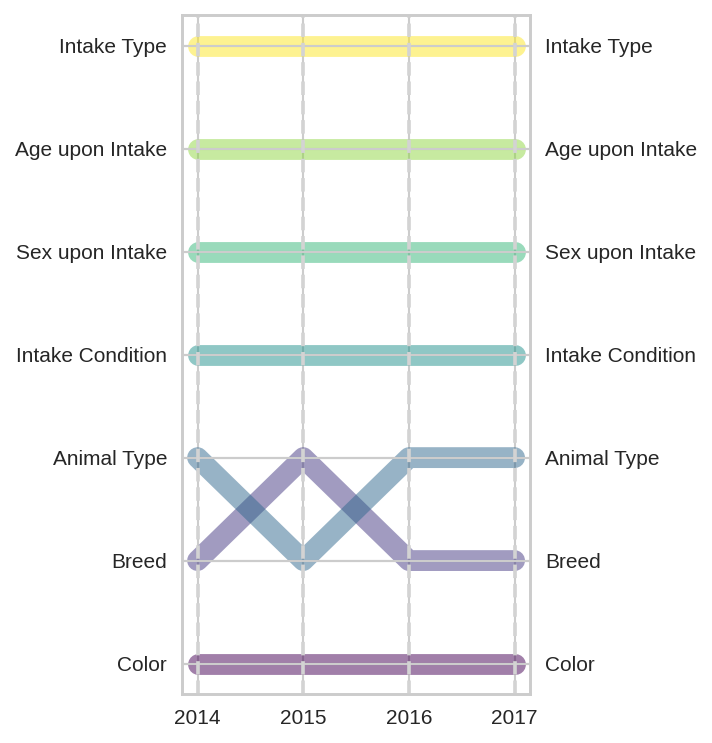

In [43]:
importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, 
                                                                                             features, 
                                                                                             save_as="../images/{}_benchmark_importance_migration_learning_curve.eps".format(PREFIX))

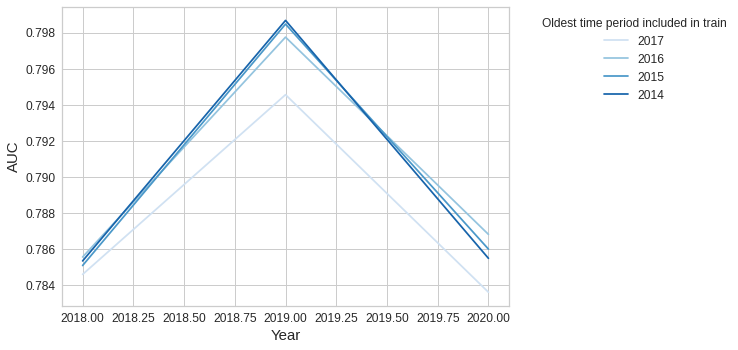

In [44]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [45]:
results

{'round': [],
 'holdout_performance': [0.78873511367752,
  0.7909901775659036,
  0.79095536324595,
  0.7909994170551025],
 'feature_importance': [Age upon Intake     0.076559
  Intake Type         0.096351
  Intake Condition    0.018458
  Animal Type         0.009803
  Sex upon Intake     0.030525
  Breed               0.003946
  Color              -0.002158
  Name: 2017, dtype: float64,
  Age upon Intake     0.077110
  Intake Type         0.096557
  Intake Condition    0.019539
  Animal Type         0.011891
  Sex upon Intake     0.034434
  Breed               0.006345
  Color               0.000599
  Name: 2016, dtype: float64,
  Age upon Intake     0.075349
  Intake Type         0.102651
  Intake Condition    0.020109
  Animal Type         0.007503
  Sex upon Intake     0.038701
  Breed               0.013611
  Color               0.000247
  Name: 2015, dtype: float64,
  Age upon Intake     0.078070
  Intake Type         0.097811
  Intake Condition    0.021180
  Animal Type         

## Challenger model

In [46]:
train.reset_index(drop=True, inplace=True)

In [47]:
train[features + [TIME_COLUMN]]

,Age upon Intake,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color,Year
0,6.000000,4,5,2,2,2231,56,2015
1,2.000000,4,5,2,2,1982,252,2017
2,1.000000,4,5,1,0,1160,489,2017
3,0.583333,2,5,2,1,1278,9,2017
4,1.000000,3,5,2,4,1563,455,2016
...,...,...,...,...,...,...,...,...
75267,0.583333,4,5,2,1,2435,530,2017
75268,1.000000,4,6,1,5,1160,155,2014
75269,1.000000,4,5,2,1,822,416,2017
75270,0.500000,4,5,2,1,822,130,2014


In [48]:
train["Year"].value_counts()

2015    19136
2017    19000
2016    18852
2014    18284
Name: Year, dtype: int64

In [49]:
out_of_time["Year"].value_counts()

2019    25595
2018    23409
2020    11404
Name: Year, dtype: int64

In [50]:
# model = TimeForestClassifier(time_column=TIME_COLUMN,
#                                         multi=True)

# challenger_opt_param = env_wise_hyper_opt(train[features + [TIME_COLUMN]], 
#                                           train[TARGET], 
#                                           model, 
#                                           TIME_COLUMN,
#                                           params_grid,
#                                           cv=5,
#                                           score=roc_auc_score)

challenger_opt_param = {'max_depth': 12,
                         'min_impurity_decrease': 0,
                         'min_sample_periods': 1,
                         'n_estimators': 120,
                         'period_criterion': 'avg'}

In [51]:
challenger_opt_param

{'max_depth': 12,
 'min_impurity_decrease': 0,
 'min_sample_periods': 1,
 'n_estimators': 120,
 'period_criterion': 'avg'}

In [52]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True,
                                        **challenger_opt_param)

challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

In [53]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

0.803675751608456
0.7904664839416058
0.7907538186859091


## Feature Importance migration

In [54]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True,
                                        **challenger_opt_param)

results_trt = reverse_learning_curve(train, 
                                     out_of_time, 
                                     challenger_model, 
                                     features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5, challenger=True)

In [55]:
challenger_model_importances = results_trt["feature_importance"][-1].copy(deep=True)
challenger_model_importances.rename("TRF", inplace=True)
challenger_model_importances

Age upon Intake     0.073718
Intake Type         0.078301
Intake Condition    0.018830
Animal Type         0.010672
Sex upon Intake     0.033550
Breed               0.011394
Color              -0.001734
Name: TRF, dtype: float64

In [56]:
all_models_importance = pd.DataFrame(index=features)
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)

all_models_importance.fillna(0, inplace=True)
all_models_importance

,RF,TRF
Age upon Intake,0.078070,0.073718
Intake Type,0.097811,0.078301
Intake Condition,0.021180,0.018830
Animal Type,0.012786,0.010672
Sex upon Intake,0.037164,0.033550
Breed,0.012108,0.011394
Color,0.000445,-0.001734


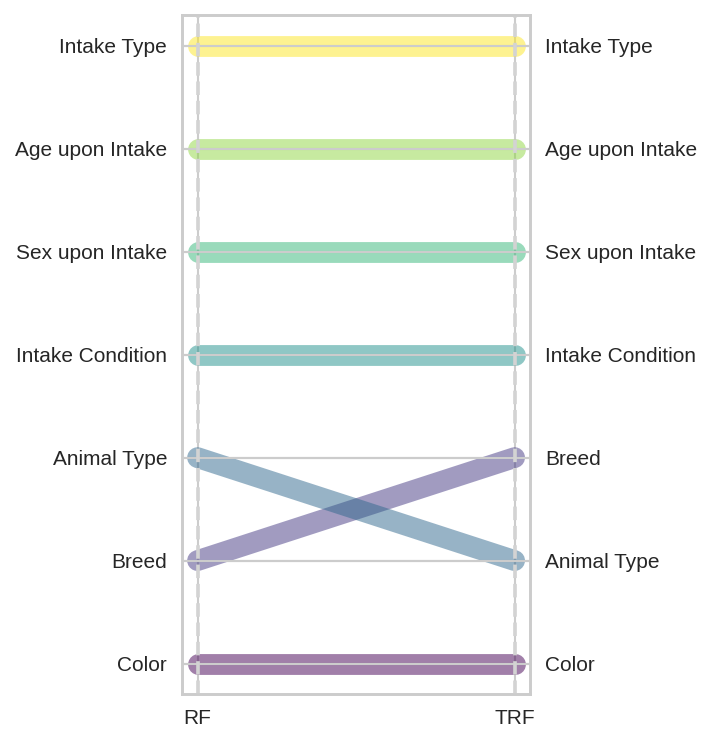

In [57]:
plot_shap_difference(all_models_importance[["RF", "TRF"]], title="", save_as="../images/{}_importance_migration.eps".format(PREFIX))

In [58]:
results_trt

{'round': [],
 'holdout_performance': [0.7883075485446309,
  0.7903391436293885,
  0.7908672983245707,
  0.7907538186859091],
 'feature_importance': [Age upon Intake     0.076248
  Intake Type         0.077971
  Intake Condition    0.018188
  Animal Type         0.010677
  Sex upon Intake     0.027157
  Breed               0.009834
  Color               0.000473
  Name: 2017, dtype: float64,
  Age upon Intake     0.076285
  Intake Type         0.079116
  Intake Condition    0.017221
  Animal Type         0.009560
  Sex upon Intake     0.031489
  Breed               0.010629
  Color               0.000021
  Name: 2016, dtype: float64,
  Age upon Intake     0.073729
  Intake Type         0.084010
  Intake Condition    0.018201
  Animal Type         0.012762
  Sex upon Intake     0.037360
  Breed               0.016339
  Color               0.000522
  Name: 2015, dtype: float64,
  Age upon Intake     0.073718
  Intake Type         0.078301
  Intake Condition    0.018830
  Animal Type     

## Reverse Learning Curve

,2017,2016,2015,2014
Age upon Intake,0.076248,0.076285,0.073729,0.073718
Intake Type,0.077971,0.079116,0.084010,0.078301
Intake Condition,0.018188,0.017221,0.018201,0.018830
Animal Type,0.010677,0.009560,0.012762,0.010672
Sex upon Intake,0.027157,0.031489,0.037360,0.033550
Breed,0.009834,0.010629,0.016339,0.011394
Color,0.000473,0.000021,0.000522,0.001734


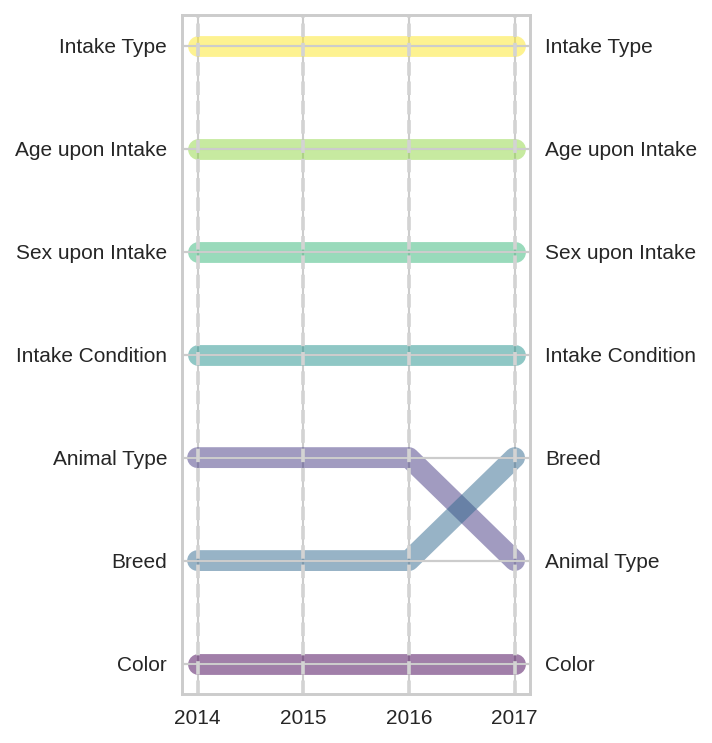

In [59]:
importance_by_reverse_segment_challenger = plot_feature_migration_from_learning_curve_results(results_trt, features, 
                                                                                             save_as="../images/{}_challenger_importance_migration_learning_curve.eps".format(PREFIX))
importance_by_reverse_segment_challenger

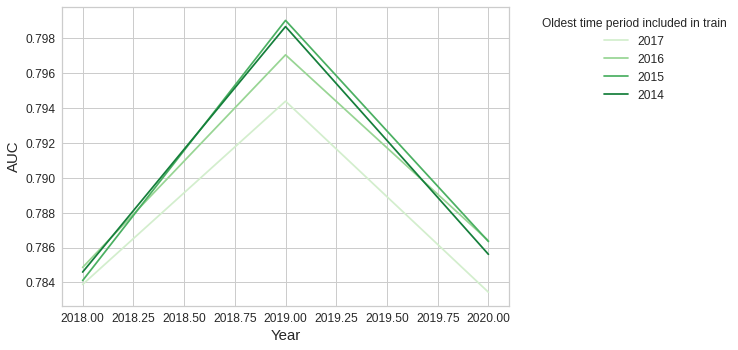

In [60]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

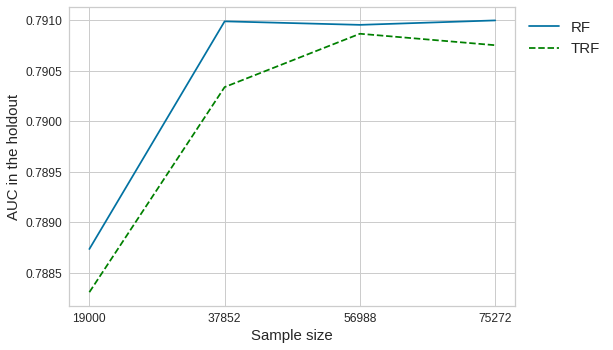

In [61]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_sample.eps".format(PREFIX), format="eps")
plt.show()

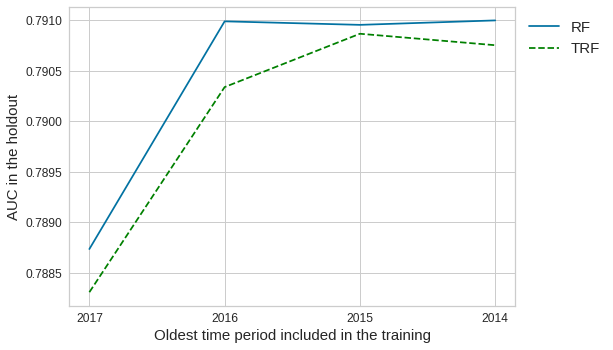

In [62]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_segments.eps".format(PREFIX), format="eps")
plt.show()

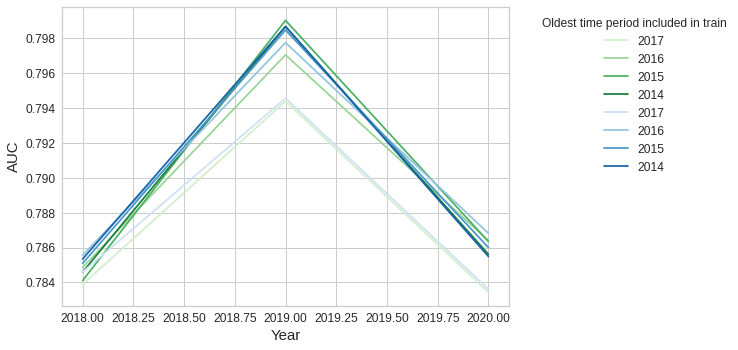

In [63]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))
    
for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_both.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

## Performance comparison

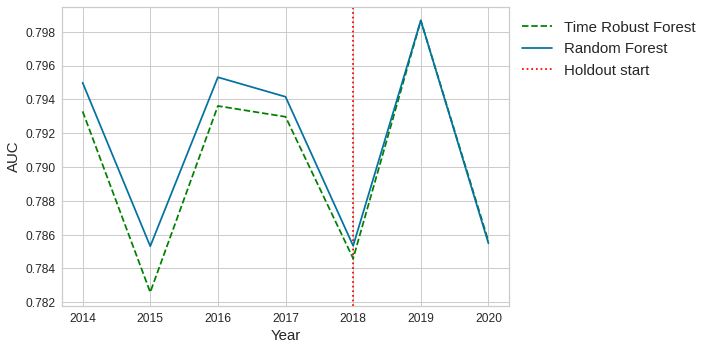

In [64]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_test_holdout_auc_years.eps".format(PREFIX), format="eps")
plt.show()

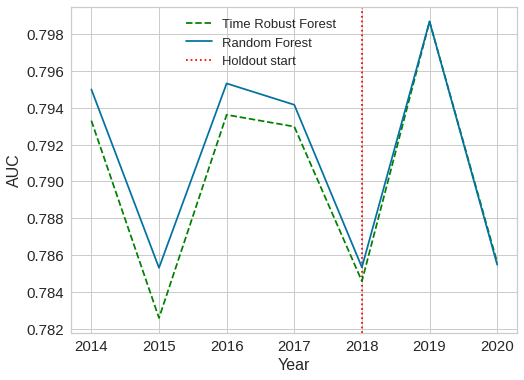

In [65]:
plt.rcParams['figure.figsize'] = (8, 6)
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=13, 
           bbox_to_anchor=(0.62, 1.0))

plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square.eps".format(PREFIX), format="eps")
plt.show()

## TRF as feature selection

In [66]:
challenger_model.feature_importance()

,Importance
Feature,
Color,13671
Breed,13181
Age upon Intake,12265
Sex upon Intake,7641
Intake Condition,4074
Intake Type,3280
Animal Type,2677


In [67]:
challenger_model.feature_importance(impurity_decrease=True)

,Importance
Feature,
Age upon Intake,3.881249
Intake Type,2.869624
Sex upon Intake,1.698359
Breed,1.551612
Color,0.903852
Animal Type,0.726405
Intake Condition,0.656525


In [68]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance().index]
selected_features

['Age upon Intake',
 'Intake Type',
 'Intake Condition',
 'Animal Type',
 'Sex upon Intake',
 'Breed',
 'Color']

In [69]:
if len(selected_features) == len(features):
    selected_features = list(challenger_model.feature_importance(impurity_decrease=True).sort_values("Importance", ascending=False).index[:int(len(features)/2)+2].values)
    
selected_features    

['Age upon Intake', 'Intake Type', 'Sex upon Intake', 'Breed', 'Color']

In [70]:
selected_features

['Age upon Intake', 'Intake Type', 'Sex upon Intake', 'Breed', 'Color']

In [71]:
clf1 = setup(train[selected_features + [TARGET]], 
             target=TARGET,
             session_id=3, 
             log_experiment=False, 
             experiment_name="{}_fs".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6886,0.7715,0.7345,0.4701,0.5733,0.3462,0.3676
1,0.6919,0.7758,0.7385,0.4738,0.5773,0.3526,0.3741
2,0.6947,0.7846,0.7558,0.4774,0.5852,0.3626,0.3866
3,0.6953,0.7886,0.7652,0.4782,0.5886,0.3665,0.3921
4,0.6960,0.7817,0.7398,0.4783,0.5810,0.3592,0.3803
Mean,0.6933,0.7805,0.7468,0.4756,0.5811,0.3574,0.3801
SD,0.0027,0.0061,0.0117,0.0032,0.0054,0.0072,0.0087


In [72]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=-1, oob_score=False,
                       random_state=3, verbose=0, warm_start=False)

In [73]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [74]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

0.7991070218021313
0.7837509391545494
0.7836641580108749


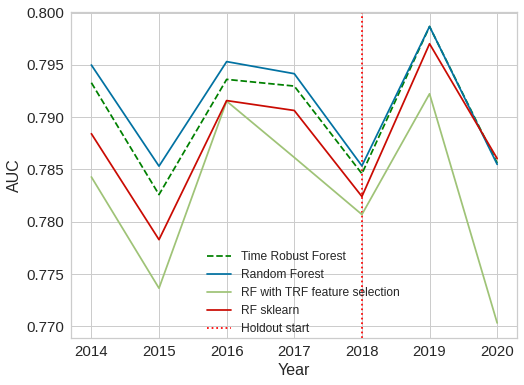

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="RF with TRF feature selection", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_sklearn"])).plot(label="RF sklearn", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=12, bbox_to_anchor=(0.52, 0.30))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square_fs.eps".format(PREFIX), format="eps")
plt.show()

## Feature Impact

In [76]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import PolyCollection as p

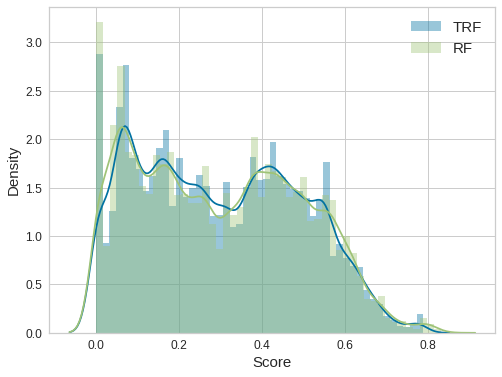

In [77]:
fig, ax = plt.subplots()

sns.distplot(out_of_time["challenger_prediction"], label="TRF")
sns.distplot(out_of_time["benchmark_prediction"], label="RF")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Density", fontsize=15)
plt.xlabel("Score", fontsize=15)

__file__ = "../images/{}_trf_rf_score_distribution".format(PREFIX)
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

ax.set_rasterized(True)
plt.savefig(__file__+".eps")        

plt.savefig("../images/{}_trf_rf_score_distribution.eps".format(PREFIX), format="eps")
plt.show()

In [78]:
ss = StandardScaler()
out_of_time["challenger_prediction_norm"] = ss.fit_transform(out_of_time[["challenger_prediction"]])
out_of_time["benchmark_prediction_norm"] = ss.fit_transform(out_of_time[["benchmark_prediction"]])

<AxesSubplot:xlabel='benchmark_prediction_norm', ylabel='Density'>

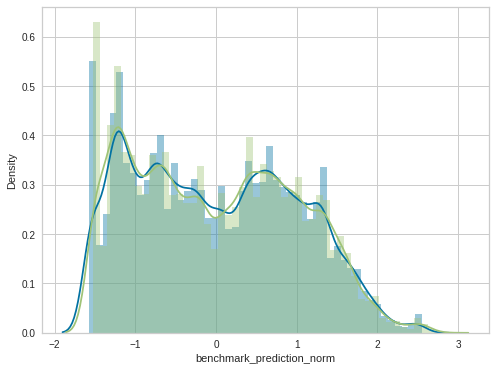

In [79]:
sns.distplot(out_of_time["challenger_prediction_norm"])
sns.distplot(out_of_time["benchmark_prediction_norm"])

In [80]:
X_train, X_test, y_train, y_test = train_test_split(out_of_time[features], 
                                                    out_of_time[["challenger_prediction", 
                                                                 "benchmark_prediction"]],
                                                    test_size=0.6,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(24163, 7)
(36245, 7)


In [81]:
numerical_features = [feature for feature in features if feature not in columns_to_label_encode]
numerical_features

['Age upon Intake']

In [82]:
p99 = X_train[numerical_features].quantile(.99)
p01 = X_train[numerical_features].quantile(.01)
p005 = X_train.quantile(.005)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] < p99, other=p99, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] < p99, other=p99, axis=1)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] > p01, other=p01, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] > p01, other=p01, axis=1)

X_train = X_train.fillna(p005)
X_test = X_test.fillna(p005)

In [83]:
dtype = ["numerical" if feature not in columns_to_label_encode else "categorical" for feature in features]

gam_challenger = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["challenger_prediction"].values)
gam_benchmark = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["benchmark_prediction"].values)

100% (11 of 11) |########################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (11 of 11) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


In [84]:
# pred_test = gam_challenger.predict(X_test[features])
# print("r2 test (challenger): %f" %r2_score(y_test["challenger_prediction"], pred_test))

# pred_test = gam_benchmark.predict(X_test[features])
# print("r2 test (benchmark): %f" %r2_score(y_test["benchmark_prediction"], pred_test))

In [85]:
X_test.describe()

,Age upon Intake,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color
count,36245.000000,36245.000000,36245.000000,36245.000000,36245.000000,36245.000000,36245.000000
mean,2.452030,3.425604,5.057636,1.755801,1.636612,1299.155608,253.818568
std,2.697392,0.924692,0.927462,0.651537,1.555336,607.192873,190.005998
min,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.666667,2.000000,5.000000,1.000000,0.000000,1088.000000,63.000000
50%,2.000000,4.000000,5.000000,2.000000,1.000000,1160.000000,192.000000
75%,3.000000,4.000000,5.000000,2.000000,2.000000,1764.000000,457.000000
max,13.000000,5.000000,9.000000,4.000000,5.000000,2621.000000,593.000000


In [86]:
import matplotlib as mpl 
mpl.rcParams['agg.path.chunksize'] = 10000

Age upon Intake
0


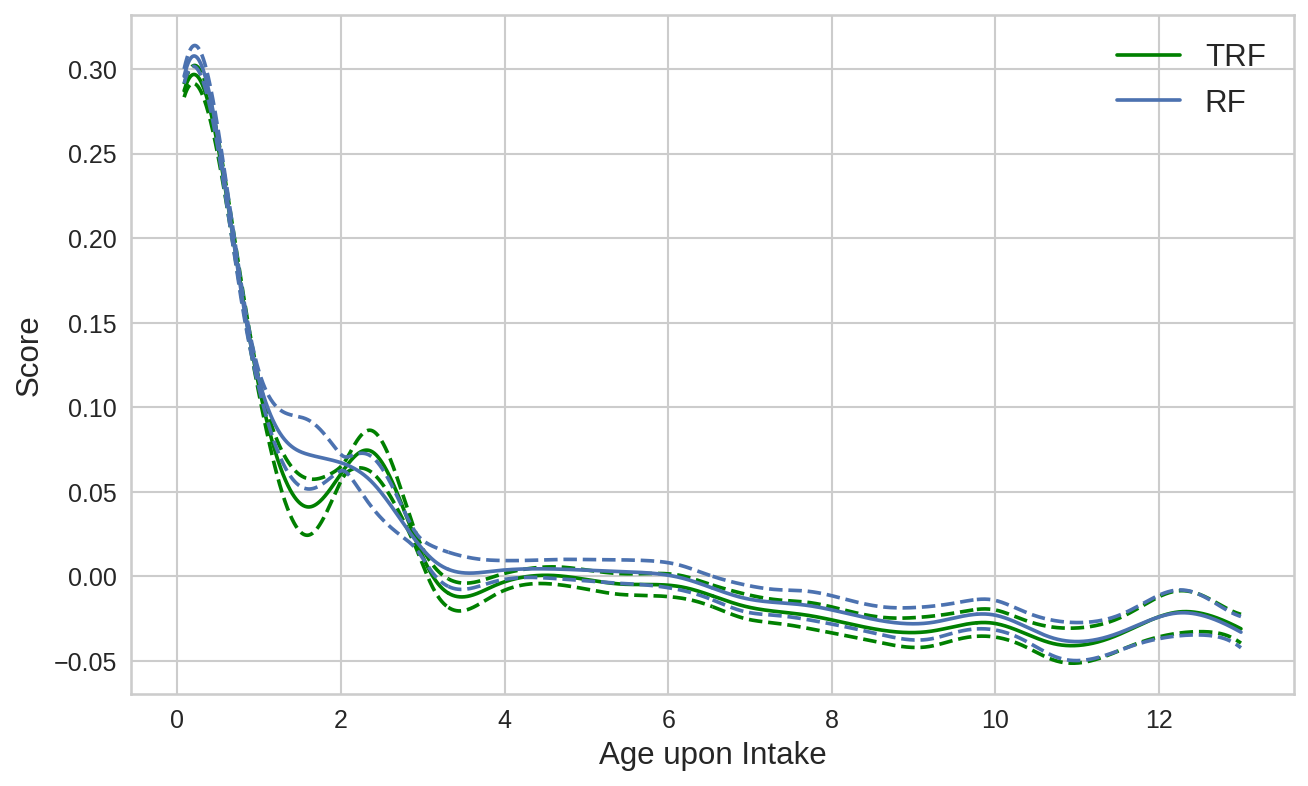

<Figure size 576x432 with 0 Axes>

In [87]:
for i, feat in enumerate(features):
    if feat not in numerical_features:
        continue
    print(feat)
    print(i)
    XX = gam_challenger.generate_X_grid(i, n=X_test.shape[0])
    ### Fix needed for this dataset
    #XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
    #XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))
    pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    plt.plot(XX[:, i], pdep, c="green", label="TRF")
    plt.plot(XX[:, i], confi, c='green', ls='--')
    plt.ylabel("Score")
    plt.legend()

    ### Benchmark
    pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
    plt.plot(XX[:, i], pdep, color="#4c72b0", label="RF")
    plt.plot(XX[:, i], confi, c='#4c72b0', ls='--')
    plt.ylabel("Score", fontsize=15)
    plt.legend()

    plt.xlabel(feat, fontsize=15)

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.ylim([ymin, ymax])
    plt.legend(fontsize=15)
    plt.savefig("../images/{}_feature_impact_{}.eps".format(PREFIX, feat), format="eps")

    plt.show()
    plt.clf()

No handles with labels found to put in legend.


Intake Type


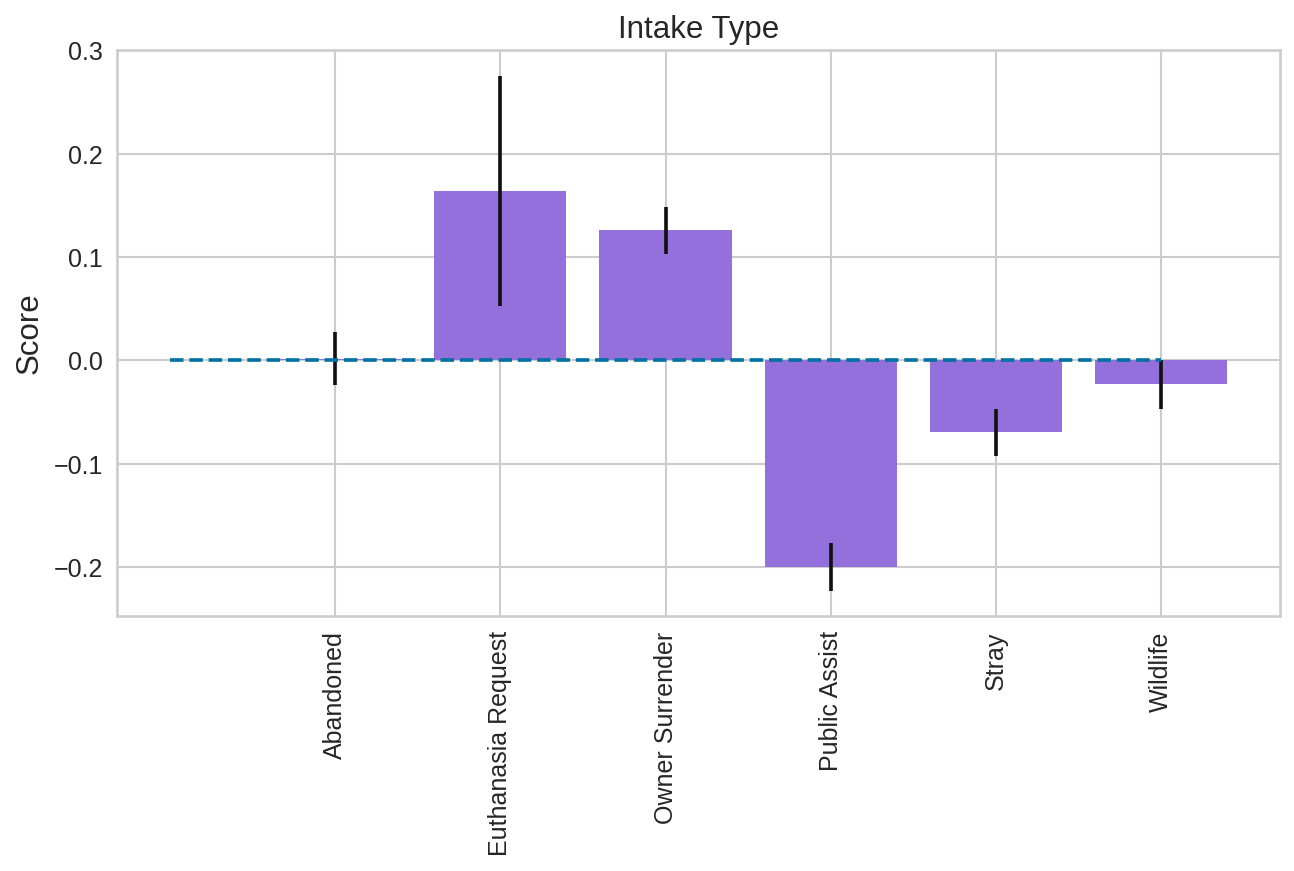

No handles with labels found to put in legend.


Intake Condition


<Figure size 576x432 with 0 Axes>

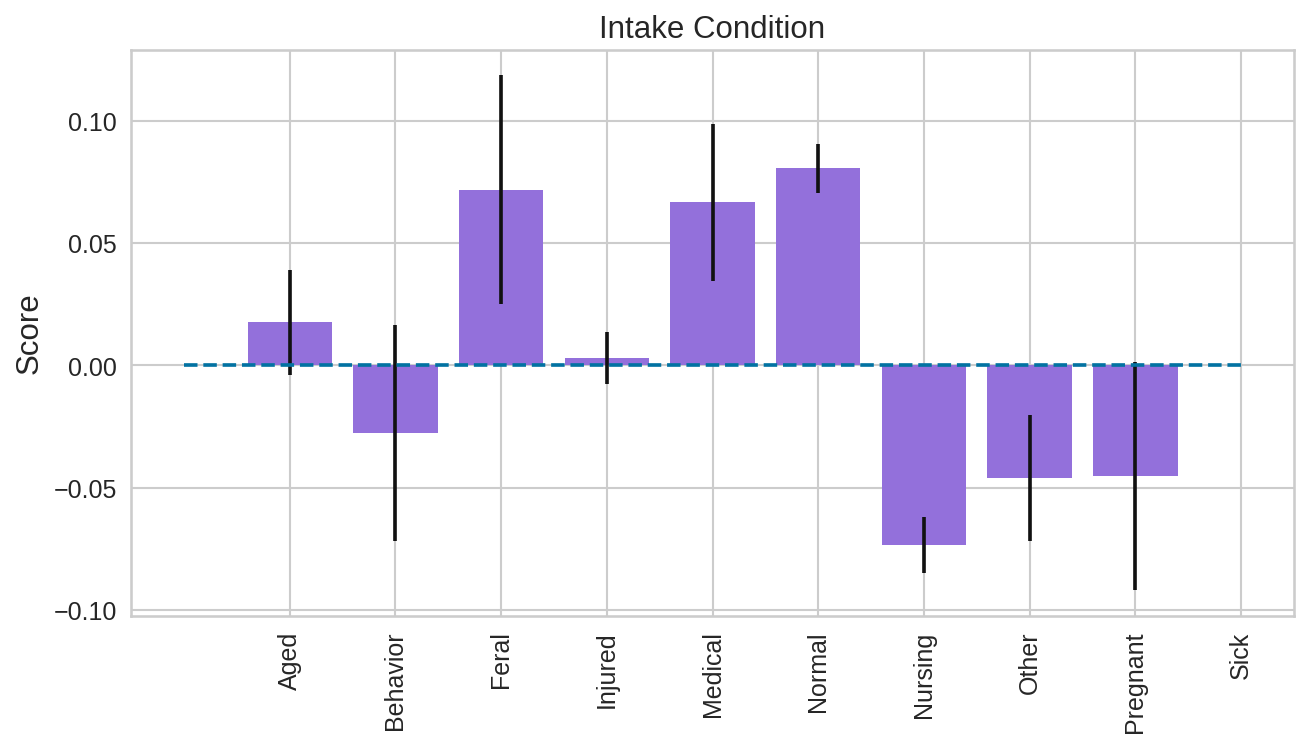

No handles with labels found to put in legend.


Animal Type


<Figure size 576x432 with 0 Axes>

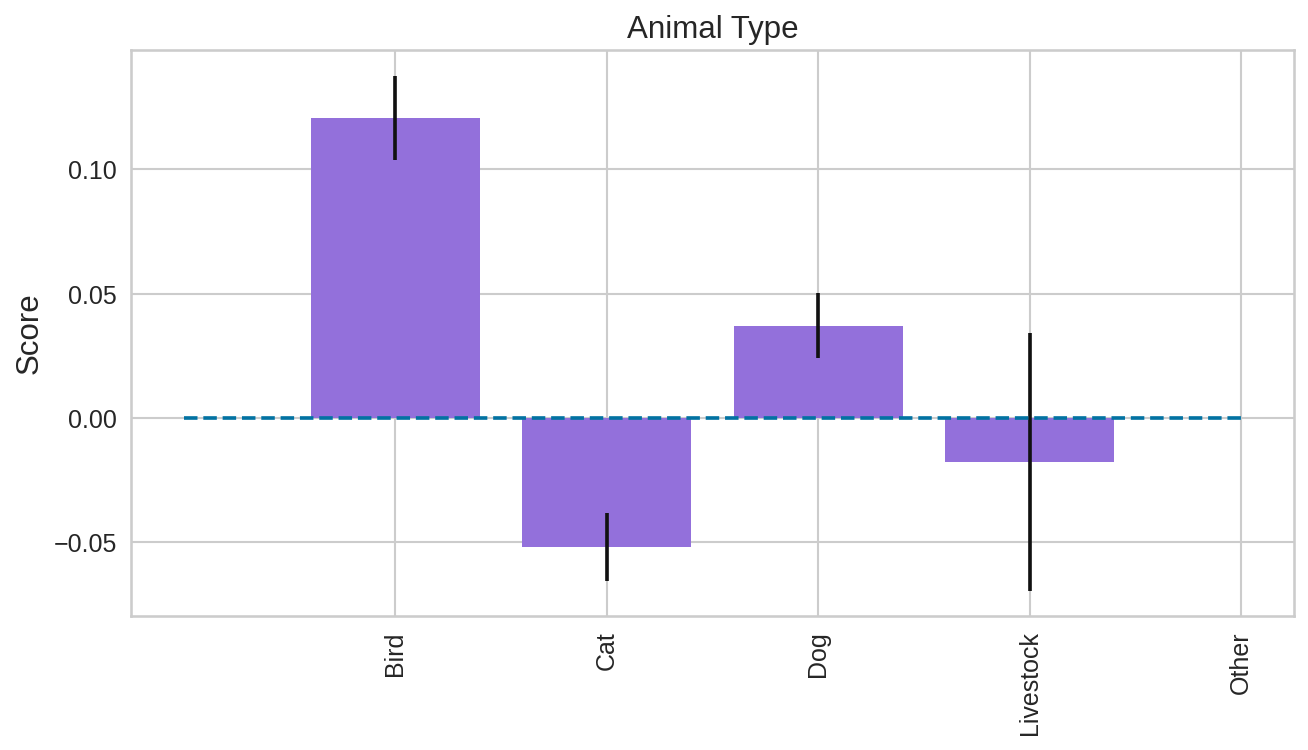

No handles with labels found to put in legend.


Sex upon Intake


<Figure size 576x432 with 0 Axes>

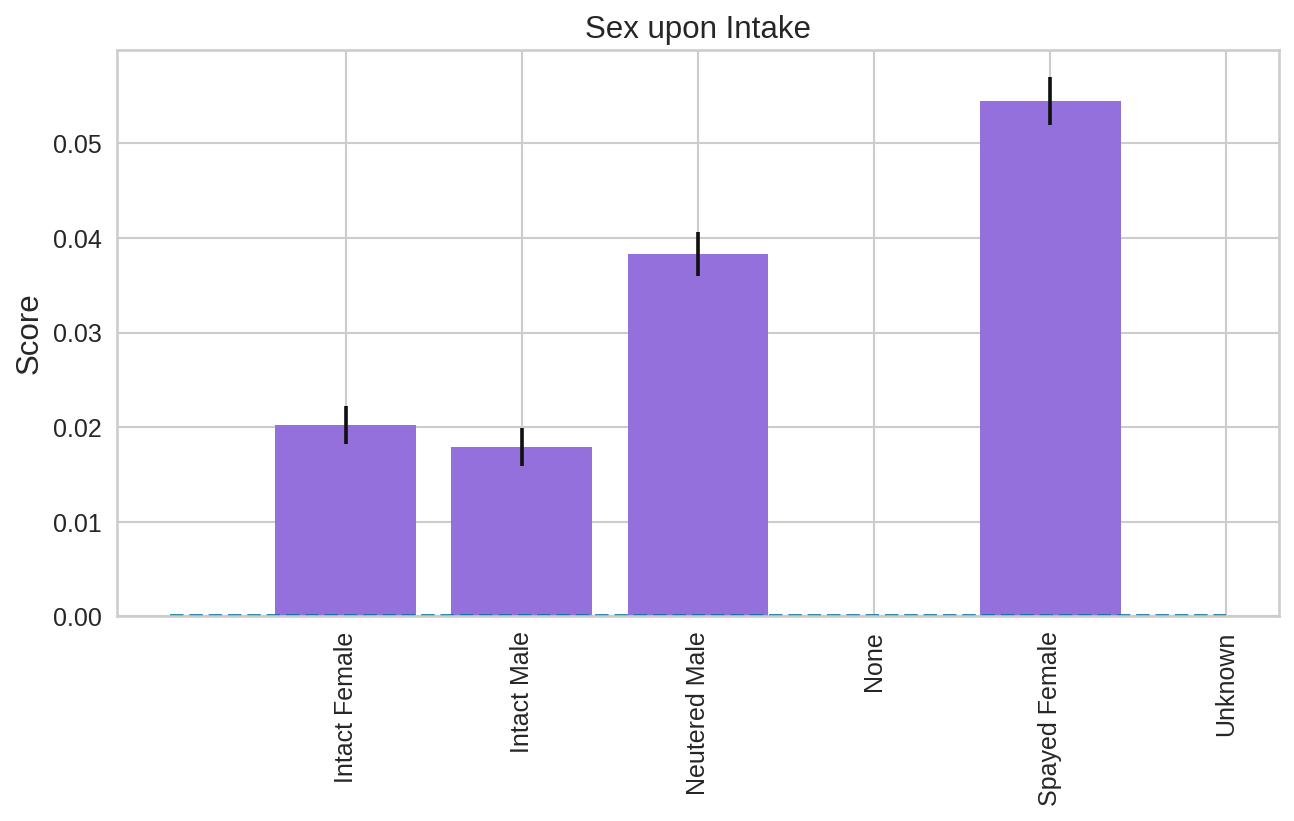

Breed
Color


<Figure size 576x432 with 0 Axes>

In [88]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        #try:
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        agg = data.groupby(feat).mean()

        impact_plot = plt.bar([i for i in range(len(agg))],
                              agg["Mean Impact"],
                              yerr=agg[["low", "high"]].values.transpose(),
                              color="#9370DB",
                              capsize=7)

        plt.title(feat, fontsize=15)
        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)

        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_{}.eps".format(PREFIX, feat), format="eps")

        plt.show()
        plt.clf()
#         except:
#             print("No plot for {}".format(feat))
plt.show()

Intake Type


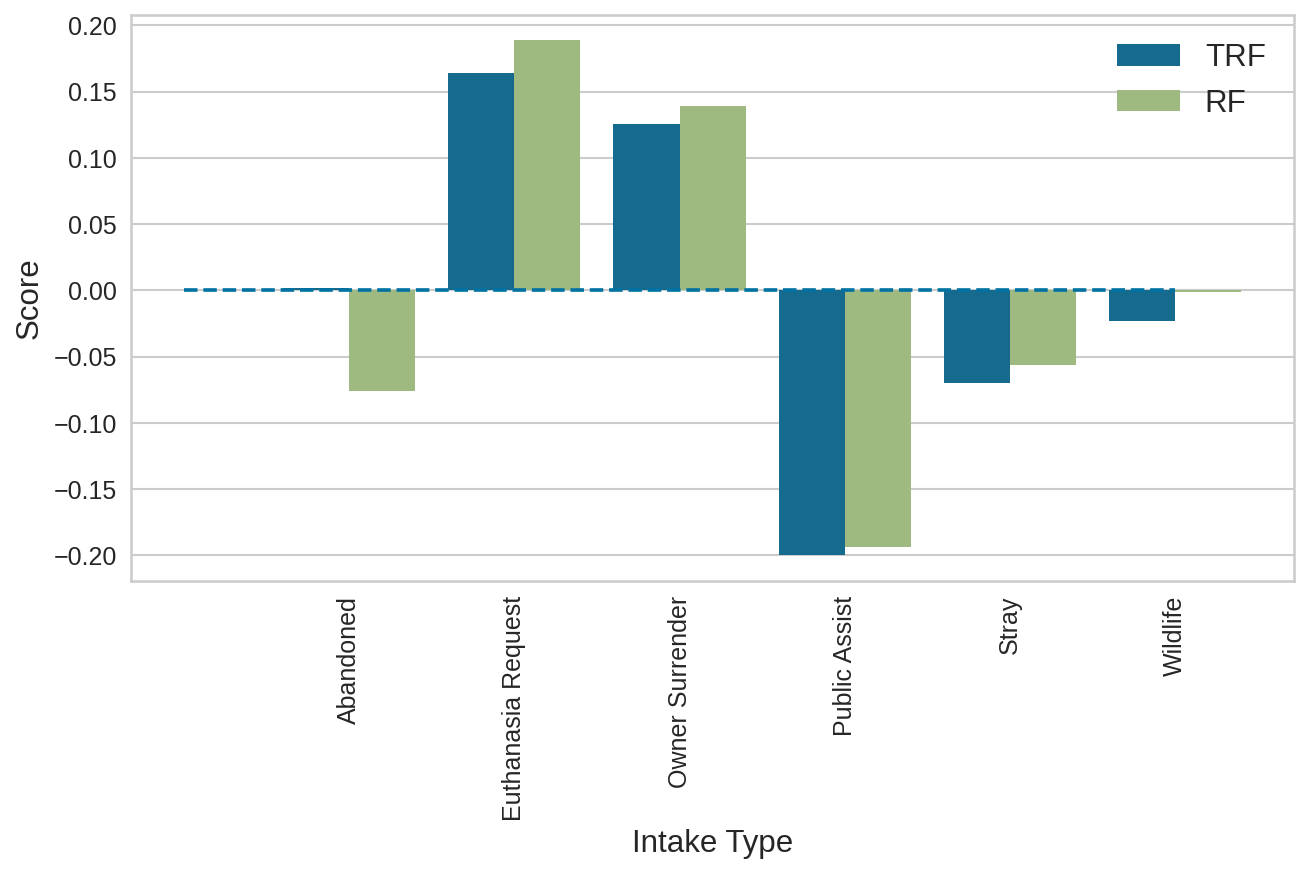

Intake Condition


<Figure size 576x432 with 0 Axes>

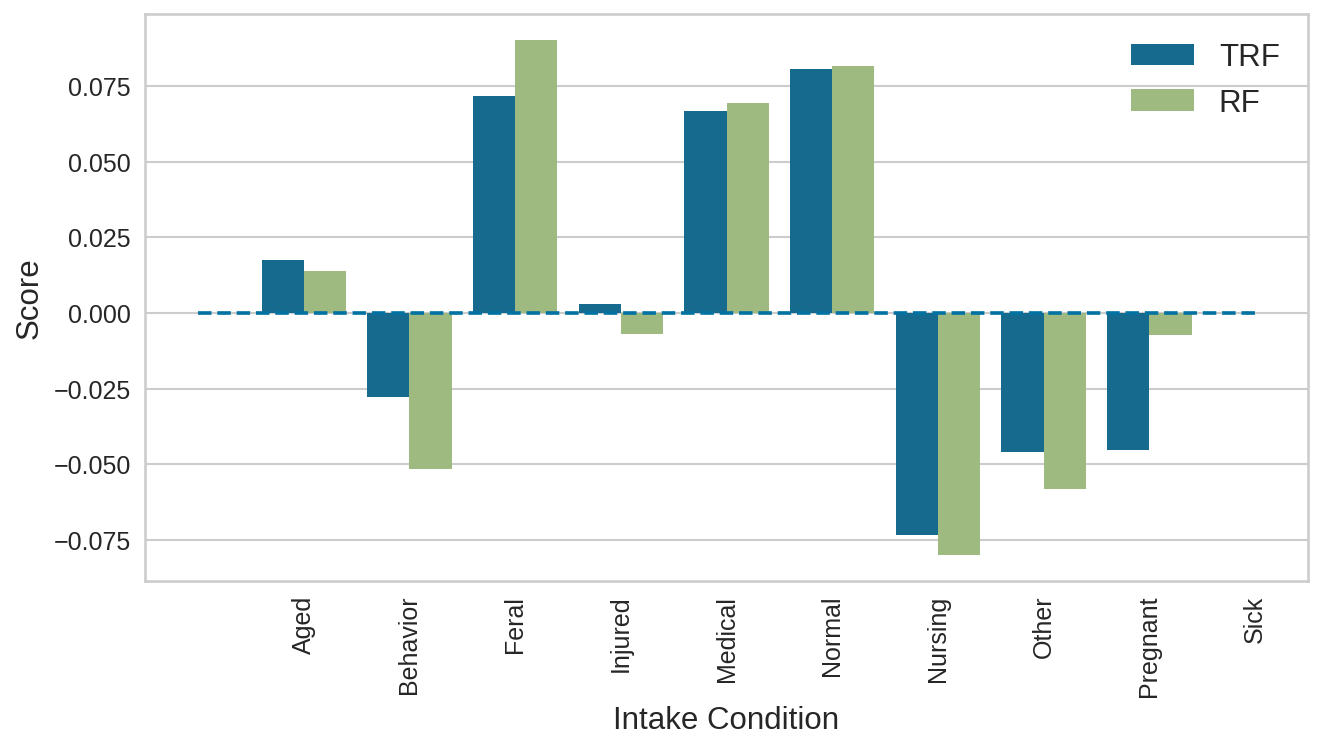

Animal Type


<Figure size 576x432 with 0 Axes>

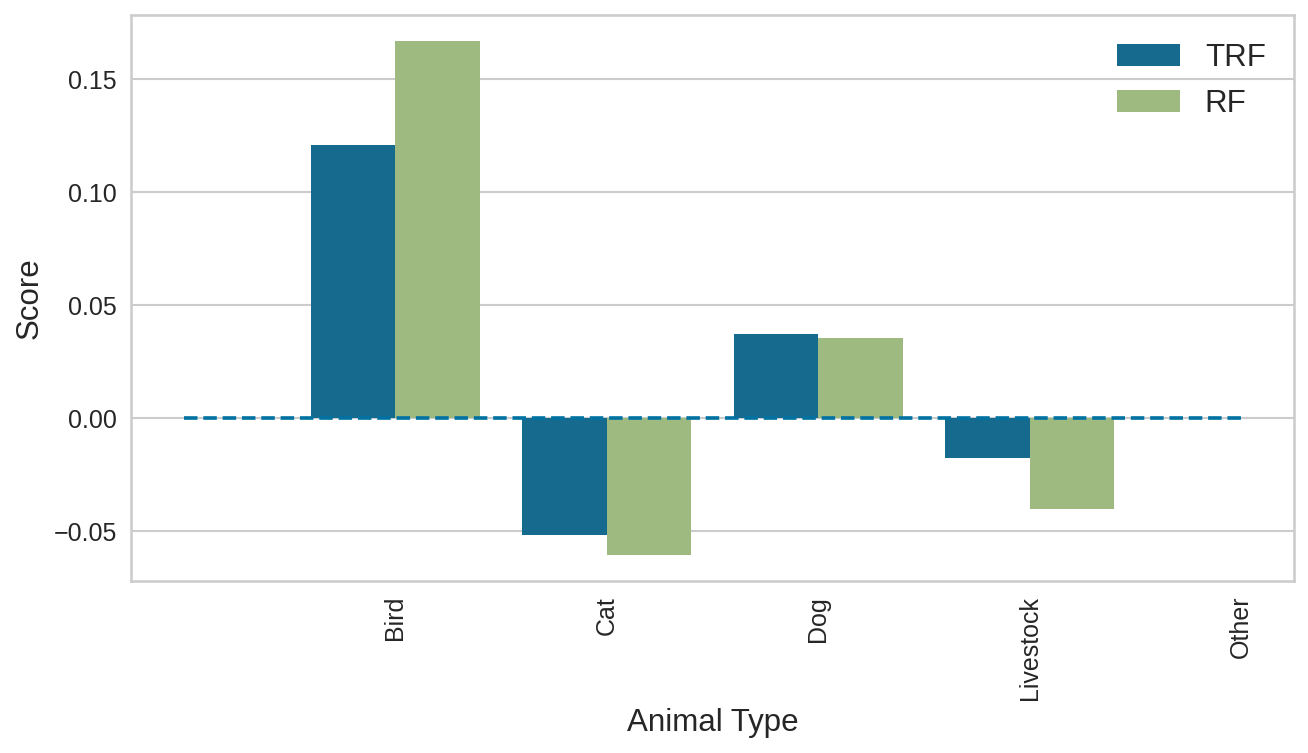

Sex upon Intake


<Figure size 576x432 with 0 Axes>

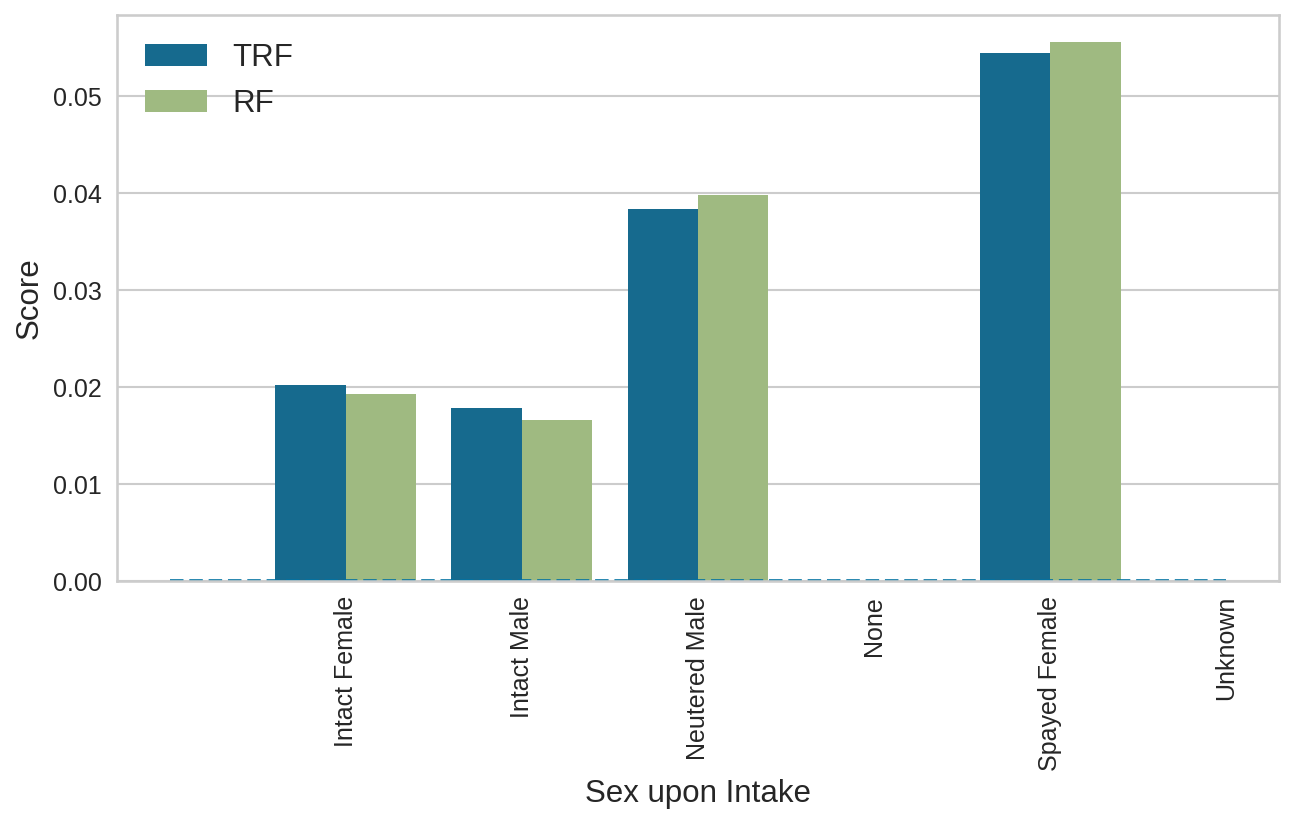

Breed
Color


<Figure size 576x432 with 0 Axes>

In [89]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))

        ### Challenger
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        data["model"] = "TRF"
        agg = data.groupby(feat).mean()


        ### Benchmark
        pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
        data_benchmark = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data_benchmark["low"] = np.abs(data_benchmark["low"] - data_benchmark["Mean Impact"])
        data_benchmark["high"] = np.abs(data_benchmark["high"] - data_benchmark["Mean Impact"])
        data_benchmark["model"] = "RF"
        
        data = pd.concat([data, data_benchmark])
        agg = data.groupby(feat).mean()
        
        sns.barplot(data=data, x=feat, y="Mean Impact", hue="model")


        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)
        
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.xlabel(feat, fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_comparison_{}.eps".format(PREFIX, feat), format="eps")
        
        plt.show()
        plt.clf()

## Minimum samples by period effect

In [90]:
target = TARGET
min_sample_periods_values = [1, 5, 10, 20, 50, 100, 250, 500]

In [91]:
min_sample_knob = {}
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

challenger_params = challenger_opt_param.copy()
challenger_params.pop("min_sample_periods")
for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=TIME_COLUMN,
                                        min_sample_periods=min_sample_periods,
                                        multi=True,
                                        **challenger_params)
    
    model_split_time.fit(train[features + [TIME_COLUMN]], train[target])
    out_of_time["time_split_prediction"] = model_split_time.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model_split_time.predict(train[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model_split_time.predict(test[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

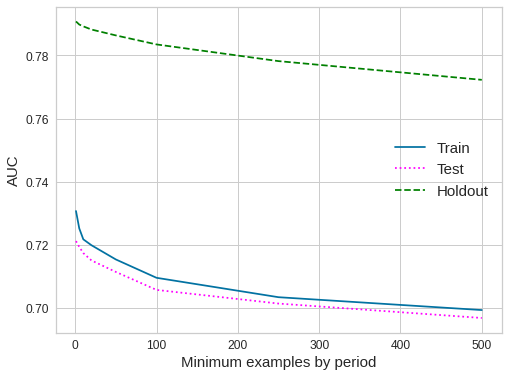

In [92]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole.eps".format(PREFIX), format="eps")
plt.show()

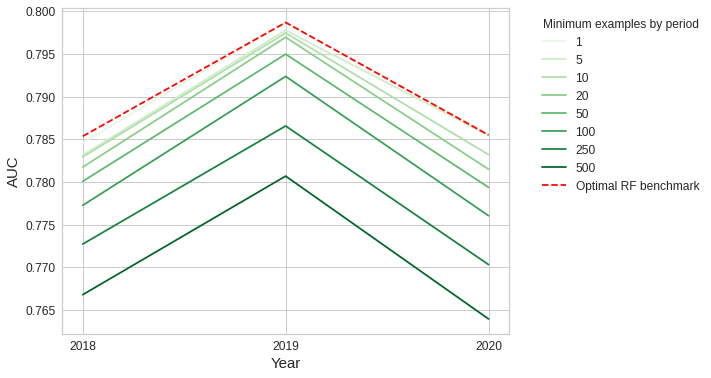

In [93]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [94]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

bench_params = benchmark_opt_param.copy()
bench_params.pop("min_sample_periods")

training_segments = train[TIME_COLUMN].nunique()
for min_sample_periods in min_sample_periods_values:

    model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       min_sample_periods=training_segments * min_sample_periods,
                                       **bench_params)
    
    
    model.fit(train[features + [DUMMY_TIME_COLUMN]],
              train[TARGET])
     
    out_of_time["time_split_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model.predict(train[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model.predict(test[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

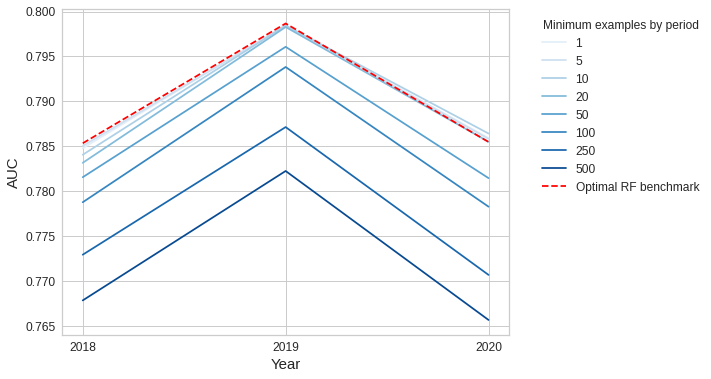

In [95]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

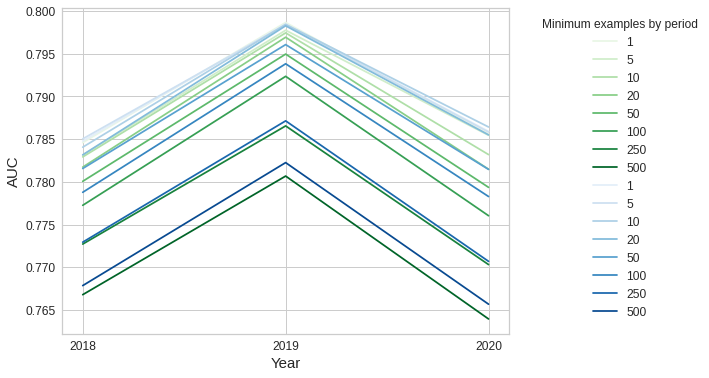

In [96]:
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

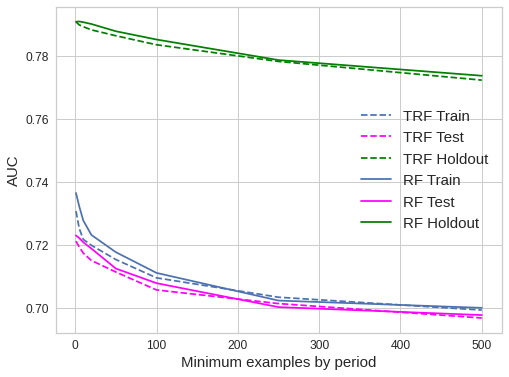

In [97]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

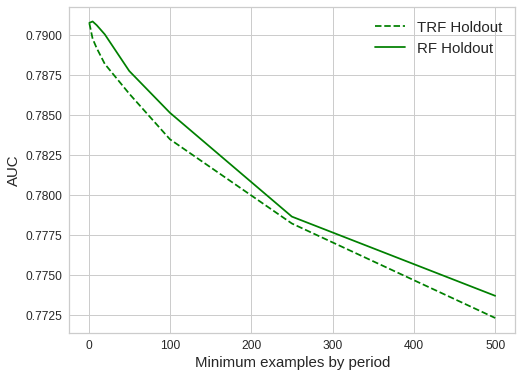

In [98]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

## Domain classifier

In [99]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [100]:
domain_data = pd.concat([train, test, out_of_time])

In [101]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [102]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6755,0.6946,0.7953,0.7080,0.7492,0.2939,0.2979
1,0.6619,0.6802,0.7712,0.7029,0.7355,0.2700,0.2723
2,0.6696,0.6897,0.7711,0.7110,0.7398,0.2891,0.2909
3,0.6627,0.6777,0.7715,0.7035,0.7360,0.2717,0.2739
4,0.6646,0.6845,0.7752,0.7042,0.7380,0.2751,0.2775
Mean,0.6668,0.6854,0.7769,0.7059,0.7397,0.2800,0.2825
SD,0.0051,0.0062,0.0094,0.0031,0.0050,0.0097,0.0101


In [103]:
domain_model = tuned_domain_rf

In [104]:
domain_model.fit(train_domain[features], train_domain["domain"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=9, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=160, n_jobs=-1, oob_score=False,
                       random_state=124, verbose=0, warm_start=False)

In [105]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [106]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.6777722853036161

## Other optimization design for the RF

In [107]:
last_time_segment_in_train = np.max(in_time[TIME_COLUMN].unique())
last_time_segment_in_train

2017

In [108]:
posfix = str(last_time_segment_in_train)

In [109]:
new_train = in_time[in_time["Year"] < last_time_segment_in_train]
new_validation = in_time[in_time["Year"] == last_time_segment_in_train]

In [110]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=44,
             log_experiment=False,
             experiment_name="{}_opt1".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                      optimize="AUC",
                      n_iter=25)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6604,0.7679,0.7819,0.4348,0.5588,0.3176,0.3539
1,0.6670,0.7680,0.7798,0.4405,0.5630,0.3260,0.3609
2,0.6709,0.7840,0.7979,0.4452,0.5715,0.3377,0.3757
3,0.6415,0.7673,0.8031,0.4206,0.5520,0.2989,0.3428
4,0.6532,0.7653,0.7793,0.4283,0.5528,0.3066,0.3435
5,0.6924,0.7775,0.7576,0.4638,0.5754,0.3554,0.3818
6,0.6915,0.7819,0.7556,0.4628,0.5740,0.3534,0.3796
7,0.7082,0.7873,0.7490,0.4806,0.5855,0.3765,0.3985
8,0.6944,0.7878,0.7862,0.4672,0.5861,0.3678,0.3992
9,0.7078,0.7965,0.7680,0.4806,0.5912,0.3821,0.4076


In [111]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0005,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=270, n_jobs=-1, oob_score=False,
                       random_state=44, verbose=0, warm_start=False)

In [112]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [113]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [114]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=22,
             log_experiment=False,
             experiment_name="{}_opt2".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6610,0.7770,0.7784,0.4426,0.5643,0.3197,0.3540
1,0.6720,0.7737,0.7844,0.4529,0.5743,0.3373,0.3711
2,0.6727,0.7734,0.7676,0.4527,0.5695,0.3328,0.3631
3,0.6631,0.7678,0.7809,0.4446,0.5666,0.3235,0.3580
4,0.6751,0.7713,0.7772,0.4556,0.5745,0.3395,0.3713
5,0.6846,0.7824,0.7668,0.4644,0.5784,0.3500,0.3781
6,0.6924,0.7805,0.7767,0.4726,0.5876,0.3648,0.3935
7,0.7038,0.7880,0.7625,0.4843,0.5923,0.3775,0.4015
8,0.7023,0.8000,0.7832,0.4830,0.5975,0.3817,0.4098
9,0.6801,0.7836,0.7918,0.4611,0.5828,0.3515,0.3855


In [115]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

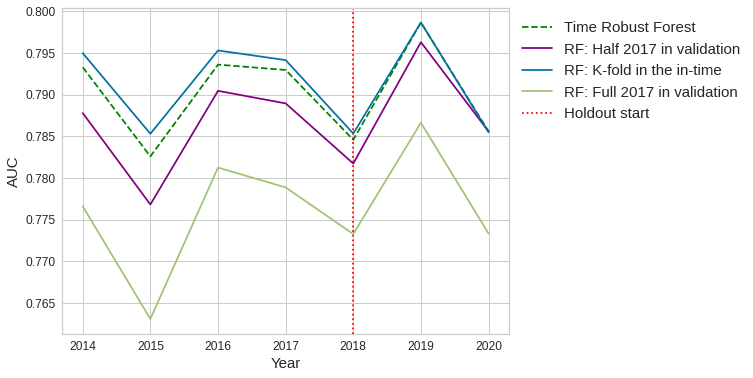

In [116]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_half_{}".format(posfix)])).plot(label="RF: Half {} in validation".format(posfix), 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_{}".format(posfix)])).plot(label="RF: Full {} in validation".format(posfix), ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_performance_proof.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()


### Sanity check

In [117]:
challenger_model_sanity = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=250,
                                        min_sample_periods=30,
                                        max_depth=11,
                                        multi=True)

challenger_model_sanity.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction_sanity"] = challenger_model_sanity.predict_proba(train[features])[:, 1]
test["challenger_prediction_sanity"] = challenger_model_sanity.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction_sanity"] = challenger_model_sanity.predict_proba(out_of_time[features])[:, 1]

print(roc_auc_score(train[TARGET], train["challenger_prediction_sanity"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction_sanity"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction_sanity"]))

0.7897224376004122
0.7829232309679842
0.7870581605155894
